In [78]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%pwd

'/home/cseadmin/data/cys/TrafficFlowModel/data_process'

In [10]:
tm=np.load("../data/trans_matrix.npy")

tm[0]

array([[1324, 1984,  520, ...,    0,    0,    0],
       [   4,  154,  514, ...,    0,    0,    0],
       [  26,  123, 5621, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ...,   37,    6,    0],
       [   0,    0,    0, ...,   23,   73,    0],
       [   0,    0,    0, ...,    0,    0,   23]], dtype=int32)

In [4]:
np.max(tm[0])

53239

In [11]:
tm_test=np.load("../data/trans_matrix_test.npy")

tm_test[0]

array([[ 42, 312,  88, ...,   0,   0,   0],
       [  3,  16,  79, ...,   0,   0,   0],
       [  3,  31, 913, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   6,   0,   0],
       [  0,   0,   0, ...,   1,  23,   0],
       [  0,   0,   0, ...,   0,   0,   5]], dtype=int32)

In [8]:
def rmse(predictions, targets):
    return np.sqrt(np.mean((predictions - targets)**2))

def mae(y_pred, y_true):
    return np.mean(np.abs((y_pred - y_true)))

def mape_no0(preds, labels):
    mask = labels != 0
    return np.fabs((labels[mask] - preds[mask]) / labels[mask]).mean()

def smape_no0(y_pred, y_true):
    mask = (y_true + y_pred != 0)
    return 2.0 * np.mean(np.abs(y_pred[mask] - y_true[mask]) / (np.abs(y_pred[mask]) + np.abs(y_true[mask])))

def maedivmean(y_pred, y_true):
    return mae(y_pred, y_true)/np.mean(y_true)

验证数据

---

In [16]:
tm[3].sum(axis=0)/6

array([262.33333333, 100.16666667, 213.83333333, ...,  10.66666667,
         8.5       ,  19.16666667])

In [13]:
tm_test[4].sum(axis=1)

array([145, 107, 199, ...,  18,   7,  26])

In [26]:
rmse(tm[3].sum(axis=0)/6, tm_test[4].sum(axis=1))
mae(tm[3].sum(axis=0)/6, tm_test[4].sum(axis=1))

39.529009443043684

11.259569945727314

In [30]:
np.mean(tm_test[4].sum(axis=1))

29.458676406859407

In [15]:
temp=np.abs(tm[3].sum(axis=0)/6 - tm_test[4].sum(axis=1))
sorted(temp, reverse=True)[:10]
np.argsort(-temp)[:10]

[1615.6666666666665,
 1248.1666666666665,
 1138.8333333333333,
 811.5,
 765.6666666666667,
 734.8333333333333,
 654.3333333333333,
 648.6666666666667,
 626.3333333333334,
 601.8333333333333]

array([11184,  7941,  7698,  4717, 12259,  3205,  8060,  2880, 13615,
       13274])

ID = 11384 哪个位置占了这么多

In [19]:
sorted(tm[3][11184, :], reverse=True)[:10]
np.argsort(-tm[3][11184, :])[:10]

[6234, 341, 192, 160, 139, 111, 82, 67, 57, 56]

array([11184, 11182, 13698, 13277, 13276, 13617,  9032,  9369,  8019,
       14653])

计算误差

---

In [9]:
def cal_error_next(n, pred, truth):
    print("RMSE = {}".format(rmse(pred[n].sum(axis=0)/6, truth[n+1].sum(axis=1))), "MAE = {}".format(mae(pred[n].sum(axis=0)/6, truth[n+1].sum(axis=1))), "MAE/mean = {}".format(maedivmean(pred[n].sum(axis=0)/6, truth[n+1].sum(axis=1))), sep="\t")
    
def cal_error(n, pred, truth):
    print("RMSE = {}".format(rmse(pred[n].sum(axis=0)/6, truth[n].sum(axis=1))), "MAE = {}".format(mae(pred[n].sum(axis=0)/6, truth[n].sum(axis=1))),"MAE/mean = {}".format(maedivmean(pred[n].sum(axis=0)/6, truth[n].sum(axis=1))), sep="\t")
    
def cal_error_comp(n, pred, truth):
    print("RMSE = {}".format(rmse(pred[n]/6, truth[n])), "MAE = {}".format(mae(pred[n]/6, truth[n])), sep="\t")
    

In [25]:
for n in range(1, 7):
    cal_error_next(n, tm, tm_test)

RMSE = 34.151135098946106 MAE = 7.980674384531253
RMSE = 24.267035444519482 MAE = 9.500959574072928
RMSE = 39.529009443043684 MAE = 11.259569945727314
RMSE = 31.091211518580096 MAE = 10.740502280278172
RMSE = 26.17701975096281 MAE = 9.108184238222002
RMSE = 34.68992303085097 MAE = 10.39747002620772


In [26]:
for n in range(1, 8):
    cal_error(n, tm, tm_test)

RMSE = 17.845472428005206 MAE = 5.512072060917476
RMSE = 14.853671415175379 MAE = 4.274231824841619
RMSE = 44.916941686488464 MAE = 13.388565591530986
RMSE = 37.8907421098149 MAE = 12.145710807074021
RMSE = 22.52380922075136 MAE = 8.045409521451123
RMSE = 28.319176716402353 MAE = 8.993293299490288
RMSE = 31.021190951082982 MAE = 9.049371633752244


自己到自己占了太多，去掉

---

In [13]:
tm_0diag=tm.copy()

for t in range(9):
    for i in range(len(tm_0diag[t])):
        tm_0diag[t][i][i]=0
        
tm_test_0diag=tm_test.copy()

for t in range(9):
    for i in range(len(tm_test_0diag[t])):
        tm_test_0diag[t][i][i]=0

In [77]:
temp2=np.abs(tm_0diag[3].sum(axis=0)/6 - tm_test_0diag[4].sum(axis=1))
sorted(temp2, reverse=True)[:10]
np.argsort(-temp2)[:10]

(tm_0diag[3].sum(axis=0)/6)[np.argsort(-temp2)[:10]]
tm_test_0diag[4].sum(axis=1)[np.argsort(-temp2)[:10]]

[667.6666666666667,
 590.8333333333333,
 514.0,
 488.33333333333337,
 474.83333333333337,
 470.83333333333337,
 438.33333333333326,
 422.66666666666663,
 356.33333333333337,
 354.0]

array([11184, 12259, 13274, 13615, 12249, 13616,  7941, 12248, 10961,
       14055])

array([1171.66666667, 1047.83333333,  960.        ,  679.33333333,
        878.83333333,  781.83333333, 1089.33333333,  751.66666667,
        744.33333333,  654.        ])

array([504, 457, 446, 191, 404, 311, 651, 329, 388, 300])

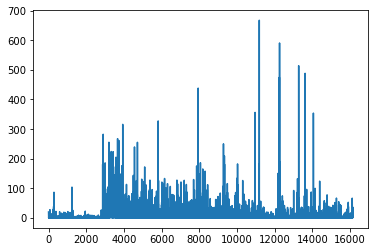

In [83]:
plt.plot(range(len(temp2)), temp2)

plt.show()

In [103]:
len(temp2)
np.sum(temp2>=300)
np.sum((temp2>=100) & (temp2<300))
np.sum((temp2>=50) & (temp2<100))
np.sum((temp2>=10) & (temp2<50))
np.sum((temp2>=5) & (temp2<10))
np.sum(temp2<5)
print("---------------------------")
np.sum(temp2<50)/len(temp2)
np.sum(temp2<40)/len(temp2)
np.sum(temp2<30)/len(temp2)
np.sum(temp2<20)/len(temp2)
np.sum(temp2<10)/len(temp2)
np.sum(temp2<5)/len(temp2)
np.sum(temp2<3)/len(temp2)
np.sum(temp2<1)/len(temp2)

16153

13

118

345

2770

2116

10791

---------------------------


0.970531789760416

0.9571596607441342

0.9349346870550362

0.8966755401473411

0.7990466167275428

0.6680492787717451

0.5618770507026558

0.3266266328236241

In [85]:
np.mean(tm_test_0diag[4].sum(axis=1))

26.16554200458119

In [14]:
for n in range(1, 7):
    cal_error_next(n, tm_0diag, tm_test_0diag)

RMSE = 23.622282058138694	MAE = 7.098454363482532	MAE/mean = 0.5688469069164418
RMSE = 20.814775944291085	MAE = 8.644782187003445	MAE/mean = 0.4891861562247476
RMSE = 23.650669921433195	MAE = 8.447089291978786	MAE/mean = 0.3228325746319273
RMSE = 20.576889119471772	MAE = 8.24854000288904	MAE/mean = 0.2634752958128418
RMSE = 16.51951798227317	MAE = 6.9337377989640725	MAE/mean = 0.22156763443668082
RMSE = 19.500113409490798	MAE = 7.659867104149899	MAE/mean = 0.2560856559000023


In [15]:
for n in range(1, 8):
    cal_error(n, tm_0diag, tm_test_0diag)

RMSE = 13.48852526426804	MAE = 4.966631585464	MAE/mean = 0.23053117052915906
RMSE = 11.65794211431183	MAE = 3.855971027053798	MAE/mean = 0.30900490157167804
RMSE = 28.63488349231344	MAE = 10.297829092635011	MAE/mean = 0.5827278608429205
RMSE = 26.797632083611315	MAE = 9.645225861037167	MAE/mean = 0.36862320143601207
RMSE = 14.394730473562012	MAE = 6.324109040632288	MAE/mean = 0.20200502145223986
RMSE = 15.149370184199947	MAE = 6.296508388534638	MAE/mean = 0.20120496466808574
RMSE = 16.565676405871397	MAE = 6.445923357890175	MAE/mean = 0.21550093344206242


直接用前6天的转移矩阵/6和第7天的对比

In [61]:
for n in range(1, 8):
    cal_error_comp(n, tm_0diag, tm_test_0diag)

RMSE = 0.057021828054658164	MAE = 0.0009889733167889009
RMSE = 0.0482158101116306	MAE = 0.0005869864846530579
RMSE = 0.10542048439497247	MAE = 0.0012340802902861402
RMSE = 0.09721171448356627	MAE = 0.0014939491654810037
RMSE = 0.06922023214072114	MAE = 0.0014144686849775297
RMSE = 0.07903273194916476	MAE = 0.001375906969547615
RMSE = 0.08018996207964632	MAE = 0.0014158203156132824


In [68]:
np.mean(tm_test_0diag[4])

0.0016198564975287062

In [69]:
mape_no0(tm_0diag[3]/6, tm_test_0diag[4])

0.7817227173231548